<a href="https://colab.research.google.com/github/strateg17/fake-news/blob/dev/Balaka_model_selection_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Бібліотеки, завантаження та підготовка данних

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from transformers import BertTokenizer, BertModel
import torch
from typing import Tuple, Dict, Callable, Any

# Завантаження та підготовка даних
df_test = pd.read_parquet('/content/english_fact_test.parquet', columns=['claim', 'label'])
df_train = pd.read_parquet('/content/english_fact_train.parquet', columns=['claim', 'label'])

df_combined = pd.concat([df_test, df_train], ignore_index=True)

label_mapping = {
    'Supported': 0,
    'Refuted': 1
}


df_combined['label'] = df_combined['label'].map(label_mapping)
#df_test['label'] = df_test['label'].map(label_mapping)
#df_train['label'] = df_train['label'].map(label_mapping)

# Remove rows where label is NaN (these were 'NEI')
df_combined = df_combined.dropna(subset=['label'])
#df_test = df_test.dropna(subset=['label'])
#df_train = df_train.dropna(subset=['label'])

# Optionally, convert the label column to integer type
df_combined['label'] = df_combined['label'].astype(int)
#df_test['label'] = df_test['label'].astype(int)
#df_train['label'] = df_train['label'].astype(int)

X = df_combined.claim
y = df_combined.label
#X_train = df_train.claim
#y_train = df_train.label
#X_test = df_test.claim
#y_test = df_test.label

# Поділ на навчальну і тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Методи трансформації тексту
def tfidf_transform(X_train: list[str], X_test: list[str]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Трансформація тексту у TF-IDF вектори.

    :param X_train: Список текстів навчальної вибірки.
    :param X_test: Список текстів тестової вибірки.
    :return: Трансформовані навчальні та тестові дані у вигляді TF-IDF векторів.
    """
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf

def word2vec_transform(X_train: list[str], X_test: list[str]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Трансформація тексту у Word2Vec вектори.

    :param X_train: Список текстів навчальної вибірки.
    :param X_test: Список текстів тестової вибірки.
    :return: Трансформовані навчальні та тестові дані у вигляді Word2Vec векторів.
    """
    model = gensim.models.Word2Vec([text.split() for text in X_train], vector_size=100, window=5, min_count=1, workers=4)
    X_train_w2v = np.array([np.mean([model.wv[word] for word in text.split() if word in model.wv] or [np.zeros(100)], axis=0) for text in X_train])
    X_test_w2v = np.array([np.mean([model.wv[word] for word in text.split() if word in model.wv] or [np.zeros(100)], axis=0) for text in X_test])
    return X_train_w2v, X_test_w2v

def doc2vec_transform(X_train: list[str], X_test: list[str]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Трансформація тексту у Doc2Vec вектори.

    :param X_train: Список текстів навчальної вибірки.
    :param X_test: Список текстів тестової вибірки.
    :return: Трансформовані навчальні та тестові дані у вигляді Doc2Vec векторів.
    """
    tagged_data = [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(X_train)]
    model = Doc2Vec(tagged_data, vector_size=100, window=5, min_count=1, workers=4)
    X_train_d2v = np.array([model.infer_vector(text.split()) for text in X_train])
    X_test_d2v = np.array([model.infer_vector(text.split()) for text in X_test])
    return X_train_d2v, X_test_d2v

def transformer_embeddings(X_train: list[str], X_test: list[str]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Трансформація тексту у векторні подання за допомогою BERT.

    :param X_train: Список текстів навчальної вибірки.
    :param X_test: Список текстів тестової вибірки.
    :return: Трансформовані навчальні та тестові дані у вигляді BERT векторів.
    """
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    def encode(texts: list[str]) -> np.ndarray:
        inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state[:, 0, :].numpy()

    X_train_bert = encode(X_train)
    X_test_bert = encode(X_test)
    return X_train_bert, X_test_bert

In [18]:
# Функція для оцінки моделей
def evaluate_models(models: Dict[str, Any], X_train: np.ndarray, y_train: np.ndarray) -> Dict[str, Tuple[float, float]]:
    """
    Оцінка моделей за допомогою перехресної валідації.

    :param models: Словник моделей для оцінки.
    :param X_train: Трансформовані навчальні дані.
    :param y_train: Мітки навчальних даних.
    :return: Словник з назвами моделей та їх середніми оцінками і стандартними відхиленнями.
    """
    results = {}
    for name, model in models.items():
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        results[name] = (np.mean(scores), np.std(scores))
        print(f"{name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    return results

In [19]:
# Список моделей для оцінки
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Bagging": BaggingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(),
    "MLP": MLPClassifier(max_iter=1000)
}


In [20]:
# Методи трансформації тексту для оцінки
transformation_methods = {
    "TF-IDF": tfidf_transform,
    "Word2Vec": word2vec_transform,
    "Doc2Vec": doc2vec_transform,
    "BERT Embeddings": transformer_embeddings
}



Оцінка моделей для методу трансформації: TF-IDF
Logistic Regression: 0.7830 ± 0.0171
Naive Bayes: 0.7610 ± 0.0118
Decision Tree: 0.7280 ± 0.0077
Random Forest: 0.7684 ± 0.0145
AdaBoost: 0.7596 ± 0.0154
Bagging: 0.7495 ± 0.0111
XGBoost: 0.7816 ± 0.0070
[LightGBM] [Info] Number of positive: 1555, number of negative: 3097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13140
[LightGBM] [Info] Number of data points in the train set: 4652, number of used features: 511
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334265 -> initscore=-0.688958
[LightGBM] [Info] Start training from score -0.688958
[LightGBM] [Info] Number of positive: 1555, number of negative: 3098
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017084 seconds.
You can set `forc

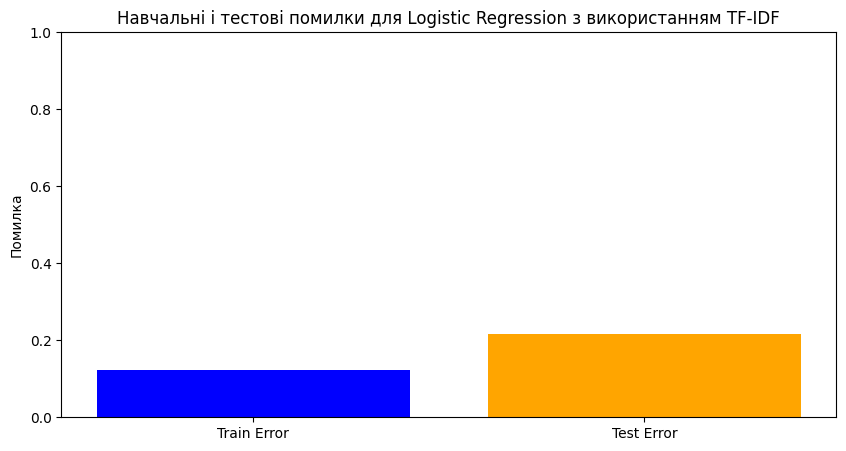


Оцінка моделей для методу трансформації: Word2Vec
Logistic Regression: 0.6902 ± 0.0066


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py", line 776, in fit
    self._count(X, Y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py", line 898, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1418, in check_non_negative
    raise ValueError("Negative values in data passed to %s" % whom)
ValueError: Negative values in data passed to MultinomialNB (input X)


In [21]:
# Оцінка моделей для різних способів трансформації тексту
for method_name, transform in transformation_methods.items():
    print(f"\nОцінка моделей для методу трансформації: {method_name}")

    # Трансформація даних
    X_train_transformed, X_test_transformed = transform(X_train, X_test)

    # Оцінка моделей
    results = evaluate_models(models, X_train_transformed, y_train)

    # Вибір найкращої моделі для поточного методу трансформації
    best_model_name = max(results, key=lambda k: results[k][0])
    best_model = models[best_model_name]
    print(f"\nНайкраща модель для {method_name}: {best_model_name} з точністю {results[best_model_name][0]:.4f}")

    # Навчання та оцінка найкращої моделі на тестовій вибірці
    best_model.fit(X_train_transformed, y_train)
    y_pred_train = best_model.predict(X_train_transformed)
    y_pred_test = best_model.predict(X_test_transformed)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    print(f"Точність на навчальній вибірці для {method_name}: {train_accuracy:.4f}")
    print(f"Точність на тестовій вибірці для {method_name}: {test_accuracy:.4f}")

    # Візуалізація тренувальних і тестових помилок
    plt.figure(figsize=(10, 5))
    plt.bar(['Train Error', 'Test Error'], [1 - train_accuracy, 1 - test_accuracy], color=['blue', 'orange'])
    plt.title(f'Навчальні і тестові помилки для {best_model_name} з використанням {method_name}')
    plt.ylabel('Помилка')
    plt.ylim(0, 1)
    plt.show()